In [39]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics 
import scipy.io as spio
from nilearn.input_data import MultiNiftiMasker
from datetime import datetime

from sklearn.metrics import make_scorer,roc_auc_score,f1_score
from sklearn.model_selection import StratifiedKFold

absolute_path_fmri = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/arcsin_CSF_pop_tpms_0p9_eroded/'
mask = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/temp/GM_mask.nii'




# reading nifti files form the subjs folder
def read_nifti(absolute_path, regex_filter, smooth=None, mask=None):
    mask=mask
    start_time = datetime.now()
    print(start_time)
    regex_filter = str(regex_filter)
    # mask images and get data
    data_folder = str(absolute_path)
    if(mask==None):
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2)
    else:
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2, mask_img=mask)
    list_path = []
    subjs = []
    i = 0
    for dirs in os.listdir(data_folder):
        for root, dir, files in os.walk(data_folder + dirs):
            for file in files:
                if re.match(regex_filter, file):
                    matter_volume_path = root + '/' + file
                    list_path.append(matter_volume_path)
                    subjs.append(dirs)
                else:
                    pass
        i = i + 1
    print("Reading " + regex_filter + " volume data please wait.........")
    list_path = np.sort(list_path)
    subjs = np.sort(subjs)
    x = niftimasker.fit_transform(list_path)
    x = np.vstack(x)
    subjects_id = pd.DataFrame()
    subjects_id['subjs'] = subjs
    data_matrix = pd.DataFrame(x, dtype='float64')
    end_time = datetime.now()
    time = end_time - start_time
    print("Total time in minutes :", float(time.total_seconds() / 60))
    return data_matrix, subjects_id, niftimasker



# code to split train and test dataset
def train_test_split(dataset, split=0.75):
     train = dataset.sample(frac=split, random_state=12)
     test = dataset.drop(train.index)
     return train, test
 
    

def get_data_mat(mat_url):
     dat = spio.loadmat(mat_url, squeeze_me=True)
     demo = dat['Demo']
     body = dat['Body']
     gen = dat['Gen']
     csf = dat['Csf']
     cog = dat['Cog']
     vol = dat['Vol']
     cog = cog['X'][()]
     csf = csf['X'][()]
     apoe = gen['apoe'][()]['X'][()]
     apoe = pd.DataFrame(apoe)
     apoe4 = ((apoe[0] == 4) + (apoe[1] == 4)) > 0
     delcode_data = pd.DataFrame()
     delcode_data['subjs'] = dat['IDs'][()]
     delcode_data['id'] = demo['IDn'][()]
     delcode_data['age'] = demo['age_bl'][()]
     delcode_data['bmi'] = body['bmi'][()]
     delcode_data['diag'] = demo['diag_bl'][()]
     delcode_data['sex'] = demo['sex'][()]
     delcode_data['apoe'] = apoe4
     delcode_data['edu'] = demo['edu'][()]
     delcode_data['fmem'] = cog[:,21]
     delcode_data['ptau'] = csf[:,4]
     delcode_data['abeta4240'] = csf[:,5]
     return delcode_data



In [26]:
def norm(x):
    return (x-x.mean())/(x.std())

# read data by feature (GM brain tissue types)
data1, sub1,niftimasker = read_nifti(absolute_path_fmri, 'con_0005.nii', mask=mask)


2022-06-22 11:27:51.224851
Reading con_0005.nii volume data please wait.........


/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

Total time in minutes : 0.36458209999999996


In [27]:
data1 = norm(data1)
data1 = data1.replace(np.nan, 0)

In [28]:

# reading subjects covariate data
delcode_cov = '/home/kadajji/hydra-work/delcode_cov1079.mat'
delcode_data = get_data_mat(delcode_cov)
sub1['age'] = sub1.subjs.map(delcode_data.set_index('subjs')['age'])
sub1['edu'] = sub1.subjs.map(delcode_data.set_index('subjs')['edu'])
sub1['sex'] = sub1.subjs.map(delcode_data.set_index('subjs')['sex'])
sub1['diag'] = sub1.subjs.map(delcode_data.set_index('subjs')['diag'])
sub1['fmem'] = sub1.subjs.map(delcode_data.set_index('subjs')['fmem'])
sub1['apoe'] = sub1.subjs.map(delcode_data.set_index('subjs')['apoe'])
sub1['apoe'] = sub1['apoe'].map({True:1, False:0})    


   
subjects  = sub1[['subjs', 'age', 'sex', 'edu', 'fmem', 'diag', ]]
# excluded few subjects because of inconsistency in T1w images
exclude_subjects = ['0588be6c5', '0901942a8', '0c1c5ae77', '0df733308', '0e27a6de5', '0e3cd430b', '14136a5ce', '16cf80a1a', '19f47ee32', '1ad67792f', '1d48057fd', '1ece6ef85', '1eebab647', '1ef92e9c3', '3125073f4', '3300076e2', '3a018fc24', '4210b3c88', '46c3433d4', '475b9bfe2', '503be410d', '5659a73f6', '5b8721c3f', '5cbfe44a2', '625c4e8e1', '682305c91', '6b8442bc7', '6c06ac657', '6dc95ea8c', '72984fc3b', '74d781eee', '766b96f80', '781929efb', '7a3350a22', '7c86c18fc', '7e74ee245', '85eb9b1a2', '8e66edf5e', '9489a87de', '999bf662e', '9c8c5c08c', 'a5cceacea', 'a9b3982d2', 'ad0d19af0', 'ad73d5585', 'b093bca1e', 'b393e08ba', 'bbb5dedd3', 'c88ff511b', 'cd3bf904f', 'd23ebb73d', 'd310d786d', 'd4c29fe4b', 'd7af42c4d', 'e49cecc8c', 'e7967bcd4', 'eb95738e8', 'ee19c801d', 'f0c51137c', 'f2a767eaa', 'f30441648', 'f4ba91dc6', 'fa890e12f', 'ffa620116', 'fff6c90a3']
subjects = subjects[~subjects['subjs'].isin(exclude_subjects)]

subjects = subjects.dropna()

con5 = pd.DataFrame(data1, index=subjects.index)
con5 = pd.DataFrame(np.array(con5))
subjects.index  = con5.index
    

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def create_confusion_matrix(test_label ,prediction, classifier):
    print(np.unique(test_label,return_counts=True))
    cm = confusion_matrix(test_label, prediction, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classifier.classes_)
    disp.plot()

    plt.show()

In [30]:

def plotting_roc_auc_curve(test_label, predict_test_prob):
    probs = predict_test_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(test_label, probs)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.grid()
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [31]:
def train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag):
    
    param_grid = {'C': [i for i in np.arange(0.00001,.01,0.001)],
                  'gamma': [1, 0.1],
                  'kernel': ['linear']}

    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
    # fitting the model for grid search
    grid.fit(X_train_diag, Y_train_diag.diag)

    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

    # input the best params for c=0.001 & gamma=1   
    clf = svm.SVC(kernel='linear', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)
    scores = cross_val_score(clf, X_train_diag, Y_train_diag.diag, cv=5, scoring='roc_auc')
    fit = clf.fit(X_train_diag, Y_train_diag.diag)

    predict_test_prob = clf.predict_proba(X_test_diag)

    probs = predict_test_prob[:,1]

    fpr, tpr, threshold = metrics.roc_curve(Y_test_diag.diag, probs)
    roc_auc = metrics.auc(fpr, tpr)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    y_pred = (probs > threshold[ix]).astype('float')

    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)
    plotting_roc_auc_curve(Y_test_diag.diag,predict_test_prob)
    confusion =  metrics.confusion_matrix(Y_test_diag.diag, y_pred)
    TP, TN, FP, FN = confusion[1, 1], confusion[0, 0],confusion[0, 1],confusion[1, 0]
    specificity = (TN / (TN + FP))
    sensitivity = (TP / float(FN + TP))
    
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))
    print("weighted roc auc on test set", roc_auc_score(Y_test_diag.diag,clf.predict_proba(X_test_diag)[:, 1],average='weighted'))
    print("cross validation scores", scores)
    print("Specifity and sensitivity", specificity,sensitivity)
    return clf

In [32]:
def create_train_test(subjects,con5,disease):
    
    subjects_cn_mci = subjects[(subjects['diag'] ==0) | (subjects['diag']==disease)]
    subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})
    data_cn_mci = pd.DataFrame(con5, index=subjects_cn_mci.index)
    Y_train_diag, Y_test_diag = train_test_split(subjects_cn_mci)
    X_train_diag, X_test_diag = pd.DataFrame(data_cn_mci, index=Y_train_diag.index), pd.DataFrame(con5, index=Y_test_diag.index)
    trainingsamples = np.unique(Y_train_diag.diag,return_counts=True)
    print("number of training samples " + str(trainingsamples))
    testsamples = np.unique(Y_test_diag.diag,return_counts=True)
    print("number of testing samples " + str(testsamples))

    return Y_train_diag, Y_test_diag,X_train_diag, X_test_diag


/tmp/ipykernel_6810/846717878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


number of training samples (array([0, 1]), array([120,  43]))
number of testing samples (array([0, 1]), array([32, 22]))
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.2s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.727 total time=   3.3s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.6s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.750 total time=   3.6s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.6s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.727 total time=   3.4s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   3.7s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.750 total time=   4.1s
[CV 1/5

[CV 5/5] END C=0.00901, gamma=0.1, kernel=linear;, score=0.844 total time=   4.5s
{'C': 1e-05, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1e-05, gamma=1, kernel='linear')
Best Threshold=0.242059, G-Mean=0.640
(array([0, 1]), array([32, 22]))


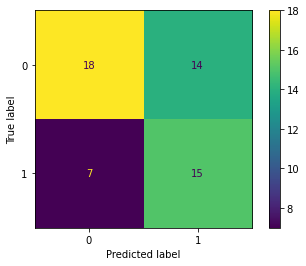

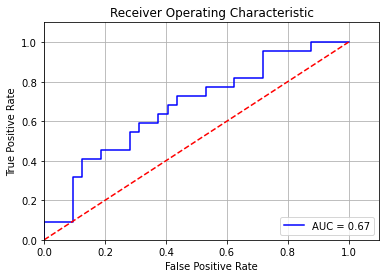

 F1 score on test set ----  0.6139204219699577
weighted roc auc on test set 0.6732954545454546
cross validation scores [0.55092593 0.86574074 0.64351852 0.67708333 0.83333333]
Specifity and sensitivity 0.5625 0.6818181818181818


In [33]:
Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,2)
clf=train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)

/tmp/ipykernel_6810/2418181505.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  stat_map = niftimasker.inverse_transform(clf.coef_).get_data()


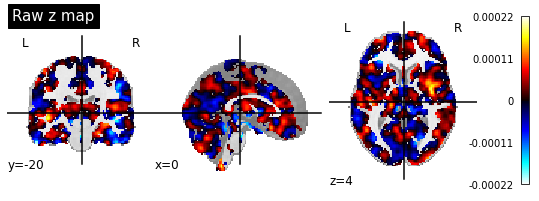

In [34]:
import nibabel as nib
import numpy as np

mean_img = nib.load(mask).get_fdata()
#mean_img  = np.nan_to_num(mean_img)
afffine = nib.load(mask).affine

header = nib.load(mask).header
stat_map = niftimasker.inverse_transform(clf.coef_).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, '/home/kadajji/hydra-work/clf_MCI_weights_single_subject_withoutBootstrap.nii')
from nilearn import plotting
display = plotting.plot_stat_map('/home/kadajji/hydra-work/clf_MCI_weights_single_subject_withoutBootstrap.nii', title='Raw z map')

/tmp/ipykernel_6810/846717878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


number of training samples (array([0, 1]), array([114,  16]))
number of testing samples (array([0, 1]), array([38,  5]))
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.846 total time=   4.0s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   4.5s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   3.6s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   4.0s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.885 total time=   4.8s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.846 total time=   3.4s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   3.7s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   4.5s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   4.0s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.885 total time=   4.1s
[CV 1/5

[CV 5/5] END C=0.00901, gamma=0.1, kernel=linear;, score=0.885 total time=   4.1s
{'C': 0.00101, 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.00101, gamma=1, kernel='linear')
Best Threshold=0.124779, G-Mean=0.827
(array([0, 1]), array([38,  5]))


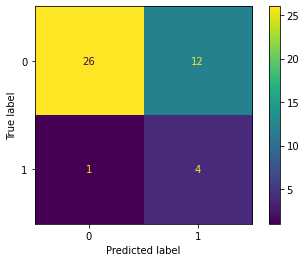

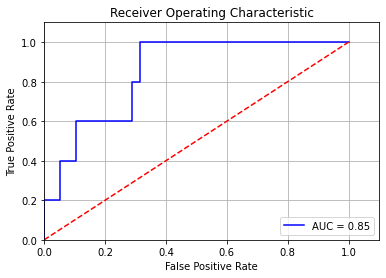

 F1 score on test set ----  0.7512735326688815
weighted roc auc on test set 0.8473684210526315
cross validation scores [0.89772727 0.84057971 0.95652174 0.60869565 0.94202899]
Specifity and sensitivity 0.6842105263157895 0.8


In [40]:
Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,5)
clf=train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)

/tmp/ipykernel_6810/3024662032.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  stat_map = niftimasker.inverse_transform(clf.coef_).get_data()


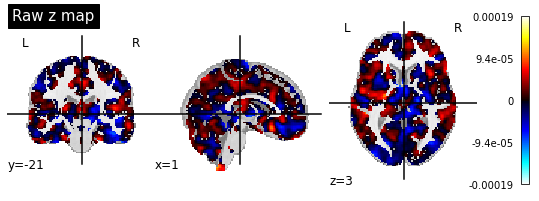

In [36]:
import nibabel as nib
import numpy as np
path="/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/arcsin_CSF_pop_tpms_0p9_eroded/011d501d1/con_0005.nii"

mean_img = nib.load(mask).get_fdata()
#mean_img  = np.nan_to_num(mean_img)
afffine = nib.load(mask).affine

header = nib.load(mask).header
stat_map = niftimasker.inverse_transform(clf.coef_).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, '/home/kadajji/hydra-work/clf_AD_weights_single_subject_withoutBootstrap.nii')
from nilearn import plotting
display = plotting.plot_stat_map('/home/kadajji/hydra-work/clf_AD_weights_single_subject_withoutBootstrap.nii', title='Raw z map')

/tmp/ipykernel_6810/846717878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


number of training samples (array([0, 1]), array([116, 150]))
number of testing samples (array([0, 1]), array([36, 53]))
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.537 total time=   7.5s
[CV 2/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.566 total time=   9.9s
[CV 3/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.585 total time=   7.7s
[CV 4/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.528 total time=   6.8s
[CV 5/5] END ...C=1e-05, gamma=1, kernel=linear;, score=0.642 total time=   9.1s
[CV 1/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.537 total time=  12.2s
[CV 2/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.566 total time=   9.5s
[CV 3/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.585 total time=   7.9s
[CV 4/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.528 total time=   7.1s
[CV 5/5] END .C=1e-05, gamma=0.1, kernel=linear;, score=0.642 total time=   9.9s
[CV 1/5

[CV 5/5] END C=0.00901, gamma=0.1, kernel=linear;, score=0.453 total time=  11.4s
{'C': 1e-05, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1e-05, gamma=1, kernel='linear')
Best Threshold=0.573028, G-Mean=0.606
(array([0, 1]), array([36, 53]))


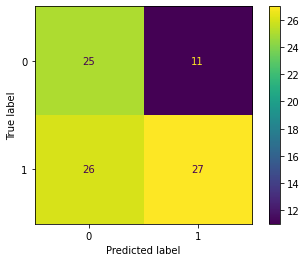

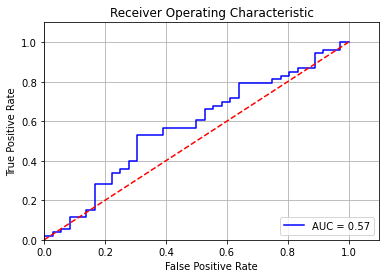

 F1 score on test set ----  0.585844995763632
weighted roc auc on test set 0.5728511530398324
cross validation scores [0.45       0.6173913  0.45217391 0.55942029 0.60289855]
Specifity and sensitivity 0.6944444444444444 0.5094339622641509


In [37]:
Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,1)
clf=train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)

/tmp/ipykernel_6810/2876501207.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  stat_map = niftimasker.inverse_transform(clf.coef_).get_data()


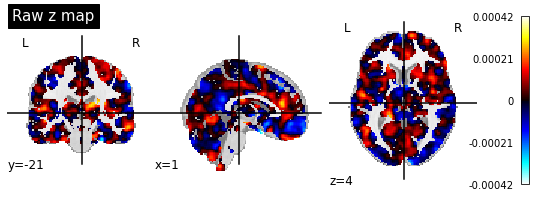

In [38]:
import nibabel as nib
import numpy as np
path="/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/arcsin_CSF_pop_tpms_0p9_eroded/011d501d1/con_0005.nii"

mean_img = nib.load(mask).get_fdata()
#mean_img  = np.nan_to_num(mean_img)
afffine = nib.load(mask).affine

header = nib.load(mask).header
stat_map = niftimasker.inverse_transform(clf.coef_).get_data()
output = nib.Nifti1Image(stat_map, header=header, affine=afffine)
nib.save(output, '/home/kadajji/hydra-work/clf_SCD_weights_single_subject_withoutBootstrap.nii')
from nilearn import plotting
display = plotting.plot_stat_map('/home/kadajji/hydra-work/clf_SCD_weights_single_subject_withoutBootstrap.nii', title='Raw z map')